In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asterion as ast
import arviz as az

ast.style.use("asterion-light")

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
numpyro.set_host_device_count(5)

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
sample = pd.read_csv("data/results/sample.csv", index_col=0)
sample.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_37,E_0_38,E_0_39,E_0_40,tau_he,delta_he,amp_he,tau_cz,dirname,log_nu_max
0,profile754,902.0,1.0,1.1,0.28,0.004097,-0.5,1.9,0.0,1.100000,...,6.374962e-09,6.853576e-09,7.506893e-09,8.421256e-09,1534.442438,795.437719,-0.001379,1354.270367,m1.1Y0.28FeH-0.5MLT1.9ov0.005000000000000001dif1,3.175834
1,profile655,803.0,1.0,1.2,0.28,0.012800,0.0,2.3,0.0,1.200000,...,1.126873e-08,8.445754e-09,7.669328e-09,7.605628e-09,1050.518944,170.639572,0.023891,2583.688281,m1.2Y0.28FeH0.0MLT2.3ov0.006444444444444444dif0,3.236161
2,profile1207,1820.0,2.0,1.4,0.28,0.038980,0.5,2.1,0.0,1.397725,...,1.169043e-05,8.456426e-05,2.761733e-04,2.276595e-05,62424.047782,9282.928284,0.061085,134563.754051,m1.4Y0.28FeH0.5MLT2.1ov0.009333333333333329dif0,1.525270
3,profile649,797.0,1.0,0.8,0.32,0.036803,0.5,2.3,0.0,0.800000,...,6.137175e-09,7.764732e-09,1.086357e-08,2.252088e-08,642.068116,64.691967,0.006260,2128.600292,m0.8Y0.32FeH0.5MLT2.3ov0.0006666666666666673dif1,3.581314
4,profile745,893.0,1.0,0.8,0.24,0.004324,-0.5,2.3,0.0,0.800000,...,1.343466e-08,1.082942e-08,1.001692e-08,9.950275e-09,900.933807,93.529779,0.005629,2448.073047,m0.8Y0.24FeH-0.5MLT2.3ov0.0006666666666666673dif1,3.408074


In [3]:
dfs = {}
for i in range(len(sample)):
    try:
        dfs[i] = pd.read_csv(f"data/results/{i}.csv")
    except FileNotFoundError:
        continue

In [4]:
results = pd.concat(dfs, names=["star", "index"]).reset_index()
results.head()

,star,index,chain,draw,log_a_he,log_b_he,log_tau_he,phi_he,log_a_cz,log_tau_cz,phi_cz,delta_nu,epsilon,he_amplitude,cz_amplitude
0,0,0,0,0,-1.632616,-5.736450,-3.002083,0.771864,6.276823,-3.003668,-1.381627,76.617424,1.034141,1.354623,1.077882
1,0,1,0,1,-1.629206,-5.730418,-3.002425,0.744334,6.270731,-3.009013,-1.208546,76.667040,1.048955,1.318275,1.062870
2,0,2,0,2,-1.588073,-5.701635,-3.002997,0.659600,6.178003,-3.005352,-1.401300,76.782642,0.980552,1.220468,0.858523
3,0,3,0,3,-1.586218,-5.698815,-3.003270,0.664460,6.170309,-3.004377,-1.434619,76.764411,0.979421,1.204741,0.843447
4,0,4,0,4,-1.714066,-5.714692,-2.985357,0.185256,6.164166,-3.011391,-0.987922,76.548671,1.041768,0.988070,0.831600


In [5]:
results = sample.merge(results, left_index=True, right_on="star")
results.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,log_b_he,log_tau_he,phi_he,log_a_cz,log_tau_cz,phi_cz,delta_nu_y,epsilon,he_amplitude,cz_amplitude
0,profile754,902.0,1.0,1.1,0.28,0.004097,-0.5,1.9,0.0,1.1,...,-5.736450,-3.002083,0.771864,6.276823,-3.003668,-1.381627,76.617424,1.034141,1.354623,1.077882
1,profile754,902.0,1.0,1.1,0.28,0.004097,-0.5,1.9,0.0,1.1,...,-5.730418,-3.002425,0.744334,6.270731,-3.009013,-1.208546,76.667040,1.048955,1.318275,1.062870
2,profile754,902.0,1.0,1.1,0.28,0.004097,-0.5,1.9,0.0,1.1,...,-5.701635,-3.002997,0.659600,6.178003,-3.005352,-1.401300,76.782642,0.980552,1.220468,0.858523
3,profile754,902.0,1.0,1.1,0.28,0.004097,-0.5,1.9,0.0,1.1,...,-5.698815,-3.003270,0.664460,6.170309,-3.004377,-1.434619,76.764411,0.979421,1.204741,0.843447
4,profile754,902.0,1.0,1.1,0.28,0.004097,-0.5,1.9,0.0,1.1,...,-5.714692,-2.985357,0.185256,6.164166,-3.011391,-0.987922,76.548671,1.041768,0.988070,0.831600


In [6]:
import seaborn as sns

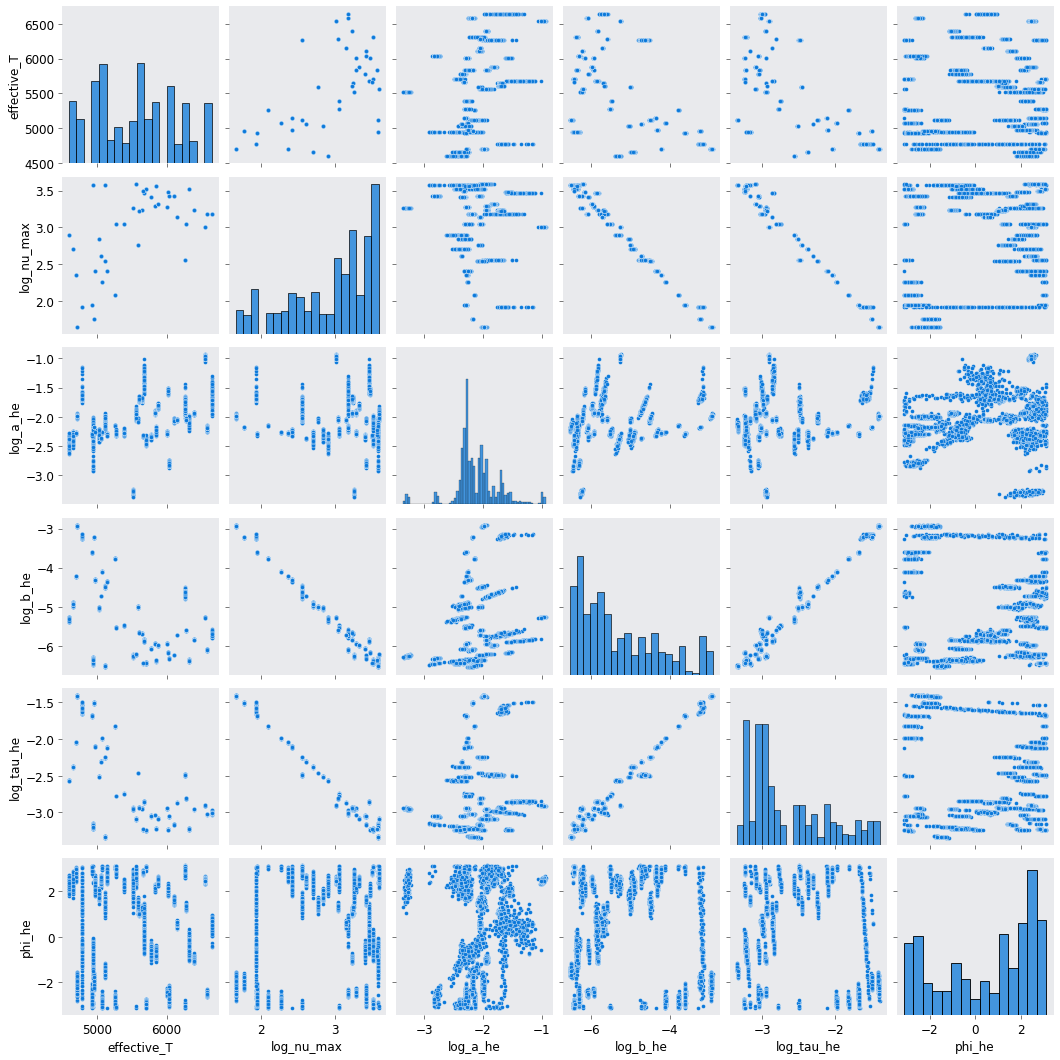

In [7]:
sns.pairplot(
    results.sample(5000), 
    vars=[
        "effective_T",
        "log_nu_max",
        "log_a_he",
        "log_b_he",
        "log_tau_he",
        "phi_he"
    ]
);

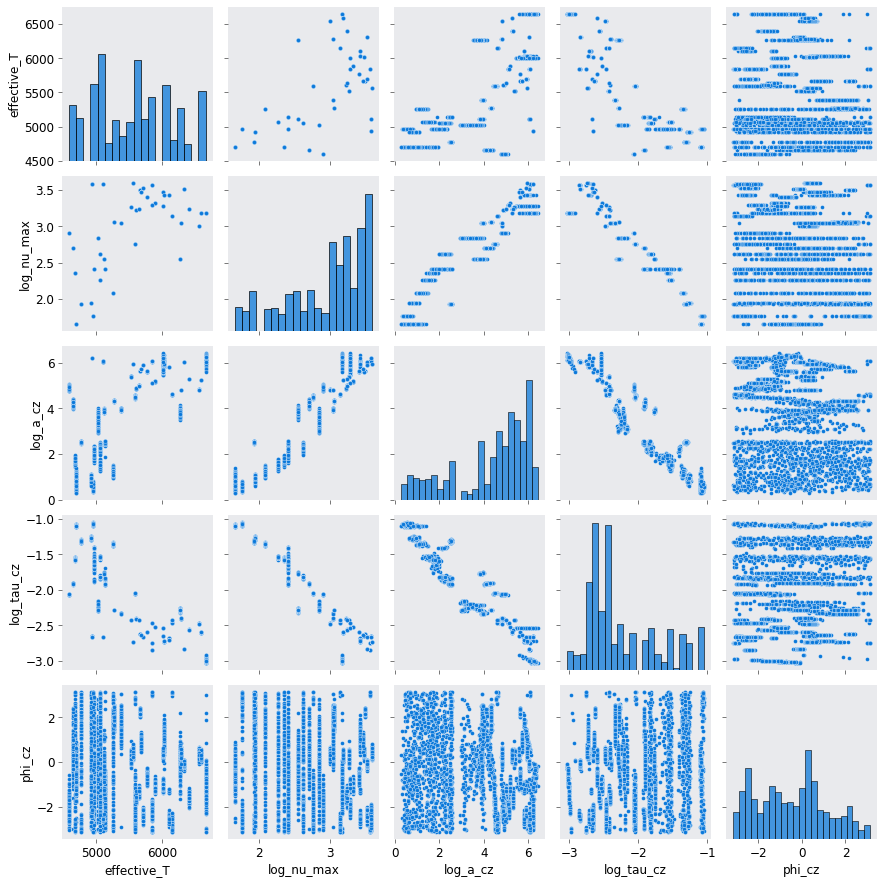

In [8]:
sns.pairplot(
    results.sample(5000), 
    vars=[
        "effective_T",
        "log_nu_max",
        "log_a_cz",
        "log_tau_cz",
        "phi_cz"
    ]
);

In [9]:
def linear_model(x, y=None):
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros(2), 10.0))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))

    numpyro.sample("y", dist.Normal(beta[0] + beta[1] * x, sigma), obs=y)

In [10]:
from numpyro.infer import NUTS, MCMC
from jax import random

In [11]:
nuts = NUTS(linear_model)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

INFO[2022-05-27 14:07:38,829]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-27 14:07:38,830]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-05-27 14:07:38,831]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [12]:
rng = random.PRNGKey(0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

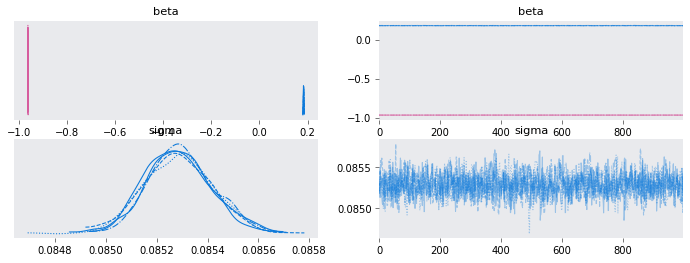

In [13]:
rng, key = random.split(rng)

mcmc.run(key, results["log_nu_max"].to_numpy(), y=results["log_tau_he"].to_numpy())
trace_tau_he = az.from_numpyro(mcmc)
az.plot_trace(trace_tau_he);

In [19]:
az.summary(trace_tau_he)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.184,0.001,0.182,0.186,0.0,0.0,2097.0,1732.0,1.0
beta[1],-0.964,0.000,-0.965,-0.963,0.0,0.0,2114.0,1992.0,1.0
sigma,0.085,0.000,0.085,0.086,0.0,0.0,1319.0,1567.0,1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

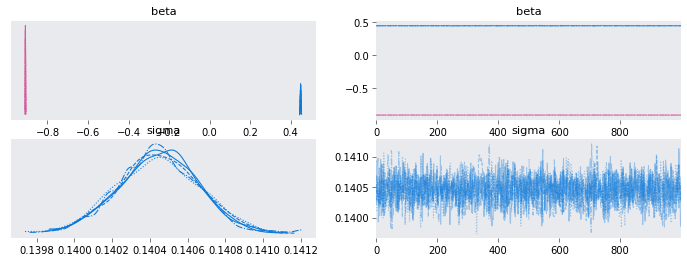

In [14]:
rng, key = random.split(rng)

mcmc.run(key, results["log_nu_max"].to_numpy(), y=results["log_tau_cz"].to_numpy())
trace_tau_cz = az.from_numpyro(mcmc)
az.plot_trace(trace_tau_cz);

In [29]:
az.summary(trace_tau_cz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.449,0.002,0.446,0.452,0.0,0.0,1733.0,1858.0,1.0
beta[1],-0.909,0.001,-0.910,-0.908,0.0,0.0,1763.0,1908.0,1.0
sigma,0.140,0.000,0.140,0.141,0.0,0.0,1916.0,1538.0,1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

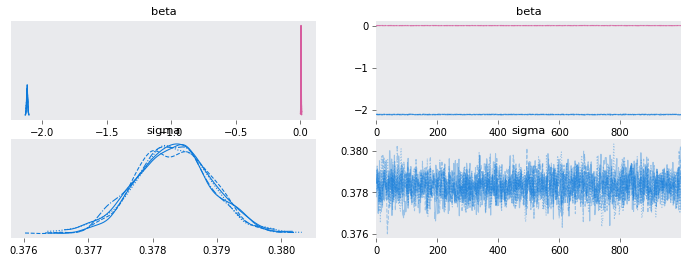

In [15]:
rng, key = random.split(rng)

mcmc.run(key, results["log_nu_max"].to_numpy(), y=results["log_a_he"].to_numpy())
trace_a_he = az.from_numpyro(mcmc)
az.plot_trace(trace_a_he);

In [30]:
az.summary(trace_a_he)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-2.119,0.005,-2.127,-2.110,0.0,0.0,1254.0,1156.0,1.00
beta[1],0.005,0.002,0.002,0.008,0.0,0.0,1283.0,1158.0,1.00
sigma,0.378,0.001,0.377,0.379,0.0,0.0,1311.0,1853.0,1.01


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

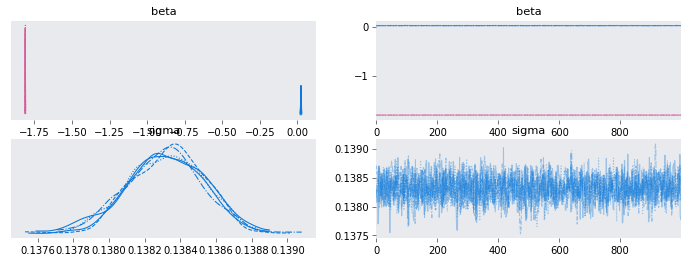

In [16]:
rng, key = random.split(rng)

mcmc.run(key, results["log_nu_max"].to_numpy(), y=results["log_b_he"].to_numpy())
trace_b_he = az.from_numpyro(mcmc)
az.plot_trace(trace_b_he);

In [31]:
az.summary(trace_b_he)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.024,0.002,0.021,0.027,0.0,0.0,1791.0,1627.0,1.0
beta[1],-1.811,0.001,-1.812,-1.810,0.0,0.0,1798.0,1648.0,1.0
sigma,0.138,0.000,0.138,0.139,0.0,0.0,1883.0,1343.0,1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

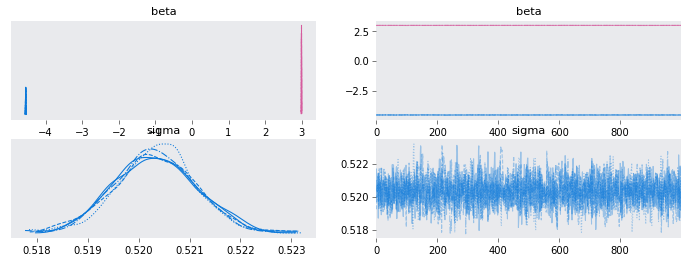

In [17]:
rng, key = random.split(rng)

mcmc.run(key, results["log_nu_max"].to_numpy(), y=results["log_a_cz"].to_numpy())
trace_a_cz = az.from_numpyro(mcmc)
az.plot_trace(trace_a_cz);

In [33]:
az.summary(trace_a_cz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-4.544,0.006,-4.556,-4.532,0.0,0.0,1246.0,1593.0,1.0
beta[1],2.995,0.002,2.991,2.999,0.0,0.0,1275.0,1555.0,1.0
sigma,0.520,0.001,0.519,0.522,0.0,0.0,2645.0,2038.0,1.0


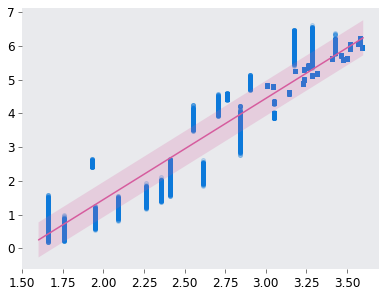

In [38]:
fig, ax = plt.subplots()

log_numax = np.linspace(1.6, 3.6)
ax.scatter(results["log_nu_max"], results["log_a_cz"], alpha=0.2)
mu = -4.544 + 2.995 * log_numax
ax.plot(log_numax, mu, color="C1")
ax.fill_between(log_numax, mu - 0.52, mu + 0.52, alpha=0.2)

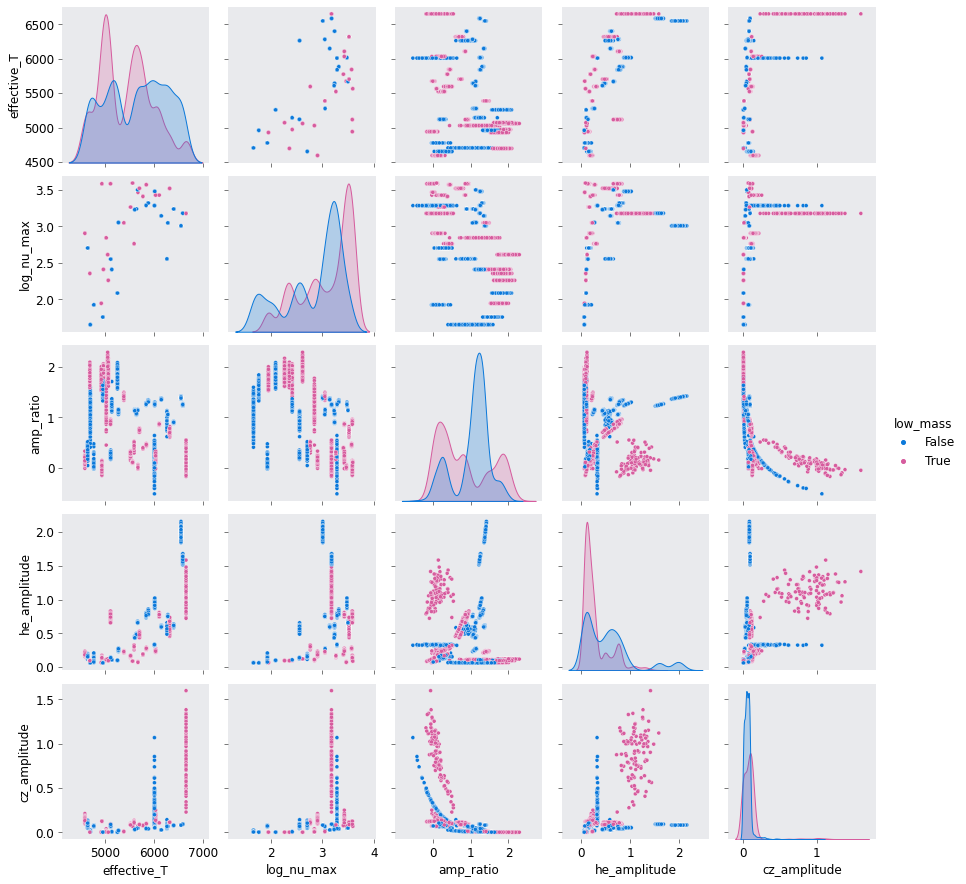

In [47]:
results["amp_ratio"] = np.log10(results["he_amplitude"] / results["cz_amplitude"])
results["low_mass"] = results["initial_mass"] < 1.15
sns.pairplot(
    results.sample(5000), 
    vars=[
        "effective_T",
        "log_nu_max",
        "amp_ratio",
        "he_amplitude",
        "cz_amplitude",
    ],
    hue="low_mass",
);

Lower mass stars seam to have a smaller amplitude ratio, meaning the base of the convective zone glitch is more obvious compared the the helium ionisation glitch?